In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, roc_curve, auc, confusion_matrix

import klib as kl 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import plotly.express as px

import seaborn as sns



In [2]:
data = pd.read_csv('all_parliament_data_no_party_removal_diputados_only.csv')

In [3]:
data = kl.clean_column_names(data)
# data

In [4]:
data.columns

Index(['text_id', 'id', 'title', 'date', 'body', 'term', 'session', 'meeting',
       'sitting', 'agenda', 'subcorpus', 'lang', 'speaker_role', 'speaker_mp',
       'speaker_minister', 'speaker_party', 'speaker_party_name',
       'party_status', 'party_orientation', 'speaker_id', 'speaker_name',
       'speaker_gender', 'speaker_birth', 'is_in_english', 'key',
       'speech_text', 'speech_text_preprocessed'],
      dtype='object')

In [5]:
# data['speaker_party'].value_counts()

In [6]:
list_of_interest_parties = ['PP', 'PSOE', 'UP', 'Vox', 'ERC-S', 'JxCat-Junts', 'EAJ-PNV', 'EH Bildu', 'CiU', 'ERC-CATSÍ']

data = data[data['speaker_party'].isin(list_of_interest_parties)]
print(data['speaker_party'].value_counts())
# data

speaker_party
PP             6358
PSOE           6230
UP             2214
Vox            1888
EAJ-PNV        1853
ERC-S          1287
JxCat-Junts    1051
EH Bildu        800
CiU             419
ERC-CATSÍ       413
Name: count, dtype: int64


In [7]:
podemos_vox = ['UP', 'Vox']

data_pv = data[data['speaker_party'].isin(podemos_vox)]
data_pv['speaker_party'].value_counts()

speaker_party
UP     2214
Vox    1888
Name: count, dtype: int64

In [8]:
erc_junts = ['ERC-S', 'JxCat-Junts', 'CiU', 'ERC-CATSÍ']

data_ej = data[data['speaker_party'].isin(erc_junts)]
data_ej['speaker_party'].value_counts()

speaker_party
ERC-S          1287
JxCat-Junts    1051
CiU             419
ERC-CATSÍ       413
Name: count, dtype: int64

In [9]:
bildu_pnv = ['EAJ-PNV', 'EH Bildu']

data_bp = data[data['speaker_party'].isin(bildu_pnv)]
data_bp['speaker_party'].value_counts()

speaker_party
EAJ-PNV     1853
EH Bildu     800
Name: count, dtype: int64

In [10]:
psoe_pp = ['PP', 'PSOE']

data = data[data['speaker_party'].isin(psoe_pp)]
data['speaker_party'].value_counts()

speaker_party
PP      6358
PSOE    6230
Name: count, dtype: int64

In [11]:
data.loc[data['speaker_party'] == 'PSOE', 'speaker_party'] = 0
data.loc[data['speaker_party'] == 'PP', 'speaker_party'] = 1

In [12]:
data_pv.loc[data_pv['speaker_party'] == 'UP', 'speaker_party'] = 0
data_pv.loc[data_pv['speaker_party'] == 'Vox', 'speaker_party'] = 1

data_ej.loc[data_ej['speaker_party'] == 'ERC-S', 'speaker_party'] = 0
data_ej.loc[data_ej['speaker_party'] == 'JxCat-Junts', 'speaker_party'] = 1
data_ej.loc[data_ej['speaker_party'] == 'CiU', 'speaker_party'] = 1
data_ej.loc[data_ej['speaker_party'] == 'ERC-CATSÍ', 'speaker_party'] = 0

data_bp.loc[data_bp['speaker_party'] == 'EH Bildu', 'speaker_party'] = 0
data_bp.loc[data_bp['speaker_party'] == 'EAJ-PNV', 'speaker_party'] = 1

In [13]:
print(data['speaker_party'].value_counts(), data_pv['speaker_party'].value_counts(), data_ej['speaker_party'].value_counts(), data_bp['speaker_party'].value_counts())

speaker_party
1    6358
0    6230
Name: count, dtype: int64 speaker_party
0    2214
1    1888
Name: count, dtype: int64 speaker_party
0    1700
1    1470
Name: count, dtype: int64 speaker_party
1    1853
0     800
Name: count, dtype: int64


In [14]:
sel_cols = ['date', 'party_status', 'speaker_party', 'speaker_gender', 'speaker_id',  'speaker_birth', 'term', 'speech_text_preprocessed']

data = data[sel_cols]
data_pv = data_pv[sel_cols]
data_ej = data_ej[sel_cols]
data_bp = data_bp[sel_cols]

In [15]:
def power_definer(df):
    df['party_in_power'] = 0
    df.loc[df['party_status'] == 'Coalition', 'party_in_power'] = 1
    df.drop(columns=['party_status'], inplace=True)

power_definer(data)
power_definer(data_pv)
power_definer(data_ej)
power_definer(data_bp)
data

,date,speaker_party,speaker_gender,speaker_id,speaker_birth,term,speech_text_preprocessed,party_in_power
0,2022-06-29,1,M,JaimeDeOlanoVela,1970,Legislatura XIV,gracias presidenta señora calviño dos último d...,0
1,2022-06-29,0,F,NadiaCalviñoSantamaría,1968,Legislatura XIV,gracias presidenta ir responder pregunta tener...,1
2,2022-06-29,1,M,JaimeDeOlanoVela,1970,Legislatura XIV,señora calviño menos mal funcionar medida infl...,0
3,2022-06-29,0,F,NadiaCalviñoSantamaría,1968,Legislatura XIV,gracia ser malo suerte señor olano poner usted...,1
5,2022-06-29,0,F,NadiaCalviñoSantamaría,1968,Legislatura XIV,gracia presidenta realidad ser semana precisam...,1
...,...,...,...,...,...,...,...,...
32544,2016-11-15,0,M,MiguelÁngelHerediaDíaz,1966,Legislatura XII,caso dinero público deber ser gastar honestida...,0
32545,2016-11-15,1,M,JaimeEduardoDeOlanoVela,1970,Legislatura XII,gracias señora presidenta debatimos hoy confor...,1
32548,2016-11-15,0,M,MiguelÁngelHerediaDíaz,1966,Legislatura XII,señora presidenta tener vídeo señor rufián cua...,0
32549,2016-11-15,0,M,MiguelÁngelHerediaDíaz,1966,Legislatura XII,evidentemente poder enseñar vídeo señora presi...,0


In [16]:
print(data['speaker_birth'].unique())
print(data_pv['speaker_birth'].unique())
print(data_ej['speaker_birth'].unique())
print(data_bp['speaker_birth'].unique())

['1970' '1968' '1967' '1966' '1959' '1962' '1976' '1978' '1965' '1977'
 '1949' '1969' '-' '1973' '1980' '1974' '1972' '1961' '1958' '1952' '1954'
 '1984' '1975' '1982' '1971' '1963' '1990' '1979' '1964' '1983' '1986'
 '1993' '1981' '1991' '1985' '1960' '1956' '1992' '1957' '1987' '1989'
 '1953' '1951' '1948' '1944' '1950' '1947' '1955' '1937' '1945' '1946'
 '1943']
['1971' '1988' '1957' '1985' '1962' '1951' '1964' '1958' '1976' '1970'
 '1972' '1965' '1968' '1963' '1960' '1974' '1969' '1979' '1973' '1966'
 '1959' '1977' '1983' '1984' '1978' '1993' '1975' '1947' '1967' '1989'
 '1980' '1952' '1986' '1955' '1987' '1981' '1956' '1961' '1950' '1990'
 '1992' '1982']
['1972' '1975' '1967' '1989' '1982' '1996' '1980' '1965' '1981' '1988'
 '1969' '1964' '1979' '1970' '1977' '1963' '1976' '1966' '1974' '1960'
 '1973' '1949' '1952' '1962' '1956' '1971' '-' '1953' '1954' '1961']
['1959' '1979' '1972' '1965' '1956' '1962' '1960' '1966' '1969' '1954'
 '1957' '1968']


In [17]:
data_ej[data_ej['speaker_birth'] == '-']

,date,speaker_party,speaker_gender,speaker_id,speaker_birth,term,speech_text_preprocessed,party_in_power
8138,2015-10-14,1,F,CarmenCastellanoiFernández,-,Legislatura X,gracias señor presidente ahora legislación mat...,0
8533,2015-10-13,1,F,CarmenCastellanoiFernández,-,Legislatura X,señor presidente señoría vaya delante unió dem...,0
9447,2015-10-01,1,F,CarmenCastellanoiFernández,-,Legislatura X,prometo aplausos,0


In [18]:
data.loc[data['speaker_id'] == 'CarmenRiobolosRegadera', 'speaker_id'] = 'CarmenRiolobosRegadera'

In [19]:
age_dict = {
    'JuanLuisSotoBurillo': 1978,
    'JoséCarlosDuránPeralta': 1987,
    'JoséCarlosDíazRodríguez': 1967,
    'CarmenRiolobosRegadera': 1953,
    'MaríaDelMarArnaizGarcía': 1966,
    'JoséIgnacioWertOrtega': 1950,
    'JoséManuelGarcíaMargalloyMarfil': 1944,
    'JulioVillarrubiaMediavilla': 1957,
    'EmilioBarbónMartínez': 1930,
    'CarmenCastellanoiFernández': 1959
}



In [20]:
# map speaker to age 
data.loc[data['speaker_birth'] == '-', 'speaker_birth'] = data.loc[data['speaker_birth'] == '-', 'speaker_id'].map(age_dict)
data_ej.loc[data_ej['speaker_birth'] == '-', 'speaker_birth'] = data_ej.loc[data_ej['speaker_birth'] == '-', 'speaker_id'].map(age_dict)
data['speaker_birth'].unique()

array(['1970', '1968', '1967', '1966', '1959', '1962', '1976', '1978',
       '1965', '1977', '1949', '1969', 1978, '1973', '1980', '1974',
       '1972', '1961', '1958', '1952', 1987, '1954', '1984', '1975',
       '1982', '1971', '1963', '1990', '1979', '1964', '1983', '1986',
       '1993', '1981', '1991', '1985', 1967, '1960', '1956', '1992',
       '1957', '1987', '1989', '1953', 1953, 1966, '1951', '1948', '1944',
       '1950', '1947', '1955', '1937', 1950, '1945', 1944, 1957, 1930,
       '1946', '1943'], dtype=object)

In [21]:
data

,date,speaker_party,speaker_gender,speaker_id,speaker_birth,term,speech_text_preprocessed,party_in_power
0,2022-06-29,1,M,JaimeDeOlanoVela,1970,Legislatura XIV,gracias presidenta señora calviño dos último d...,0
1,2022-06-29,0,F,NadiaCalviñoSantamaría,1968,Legislatura XIV,gracias presidenta ir responder pregunta tener...,1
2,2022-06-29,1,M,JaimeDeOlanoVela,1970,Legislatura XIV,señora calviño menos mal funcionar medida infl...,0
3,2022-06-29,0,F,NadiaCalviñoSantamaría,1968,Legislatura XIV,gracia ser malo suerte señor olano poner usted...,1
5,2022-06-29,0,F,NadiaCalviñoSantamaría,1968,Legislatura XIV,gracia presidenta realidad ser semana precisam...,1
...,...,...,...,...,...,...,...,...
32544,2016-11-15,0,M,MiguelÁngelHerediaDíaz,1966,Legislatura XII,caso dinero público deber ser gastar honestida...,0
32545,2016-11-15,1,M,JaimeEduardoDeOlanoVela,1970,Legislatura XII,gracias señora presidenta debatimos hoy confor...,1
32548,2016-11-15,0,M,MiguelÁngelHerediaDíaz,1966,Legislatura XII,señora presidenta tener vídeo señor rufián cua...,0
32549,2016-11-15,0,M,MiguelÁngelHerediaDíaz,1966,Legislatura XII,evidentemente poder enseñar vídeo señora presi...,0


In [22]:
data['speaker_birth'] = data['speaker_birth'].astype(int)
data_pv['speaker_birth'] = data_pv['speaker_birth'].astype(int)
data_ej['speaker_birth'] = data_ej['speaker_birth'].astype(int)
data_bp['speaker_birth'] = data_bp['speaker_birth'].astype(int)

In [23]:
def age_getter(df):
    df['date'] = pd.to_datetime(df['date'])
    df['speaker_age'] = df['date'].dt.year - df['speaker_birth']
    df.drop(columns=['speaker_birth'], inplace=True)

age_getter(data)
age_getter(data_pv)
age_getter(data_ej)
age_getter(data_bp)
data

,date,speaker_party,speaker_gender,speaker_id,term,speech_text_preprocessed,party_in_power,speaker_age
0,2022-06-29,1,M,JaimeDeOlanoVela,Legislatura XIV,gracias presidenta señora calviño dos último d...,0,52
1,2022-06-29,0,F,NadiaCalviñoSantamaría,Legislatura XIV,gracias presidenta ir responder pregunta tener...,1,54
2,2022-06-29,1,M,JaimeDeOlanoVela,Legislatura XIV,señora calviño menos mal funcionar medida infl...,0,52
3,2022-06-29,0,F,NadiaCalviñoSantamaría,Legislatura XIV,gracia ser malo suerte señor olano poner usted...,1,54
5,2022-06-29,0,F,NadiaCalviñoSantamaría,Legislatura XIV,gracia presidenta realidad ser semana precisam...,1,54
...,...,...,...,...,...,...,...,...
32544,2016-11-15,0,M,MiguelÁngelHerediaDíaz,Legislatura XII,caso dinero público deber ser gastar honestida...,0,50
32545,2016-11-15,1,M,JaimeEduardoDeOlanoVela,Legislatura XII,gracias señora presidenta debatimos hoy confor...,1,46
32548,2016-11-15,0,M,MiguelÁngelHerediaDíaz,Legislatura XII,señora presidenta tener vídeo señor rufián cua...,0,50
32549,2016-11-15,0,M,MiguelÁngelHerediaDíaz,Legislatura XII,evidentemente poder enseñar vídeo señora presi...,0,50


In [24]:
print(data.speaker_gender.unique())
print(data_pv.speaker_gender.unique())
print(data_ej.speaker_gender.unique())
print(data_bp.speaker_gender.unique())

['M' 'F' 'U']
['M' 'F']
['M' 'F']
['M' 'F']


In [25]:
data.loc[data.speaker_gender == 'U', 'speaker_gender'] = 'F'
data.speaker_gender.unique()

array(['M', 'F'], dtype=object)

In [26]:
gender_map = {
    'M': 1,
    'F': 0
}

data['speaker_gender'] = data['speaker_gender'].map(gender_map)
data_pv['speaker_gender'] = data_pv['speaker_gender'].map(gender_map)
data_ej['speaker_gender'] = data_ej['speaker_gender'].map(gender_map)
data_bp['speaker_gender'] = data_bp['speaker_gender'].map(gender_map)

print(data.speaker_gender.unique())

[1 0]


In [27]:
print(data.term.unique())
print(data_pv.term.unique())
print(data_ej.term.unique())
print(data_bp.term.unique())

['Legislatura XIV' 'Legislatura X' 'Legislatura XII' 'Legislatura XIII'
 'Legislatura XI']
['Legislatura XIV' 'Legislatura XII' 'Legislatura XIII' 'Legislatura XI']
['Legislatura XIV' 'Legislatura X' 'Legislatura XII' 'Legislatura XIII'
 'Legislatura XI']
['Legislatura XIV' 'Legislatura X' 'Legislatura XII' 'Legislatura XIII'
 'Legislatura XI']


In [28]:
# label encode term columns 
print(data.term.unique())

term_map = {
    'Legislatura X': 0,
    'Legislatura XI': 1,
    'Legislatura XII': 2,
    'Legislatura XIII': 3,
    'Legislatura XIV': 4
}

data['term'] = data['term'].map(term_map)
data_pv['term'] = data_pv['term'].map(term_map)
data_ej['term'] = data_ej['term'].map(term_map)
data_bp['term'] = data_bp['term'].map(term_map)
print(data.term.unique())

['Legislatura XIV' 'Legislatura X' 'Legislatura XII' 'Legislatura XIII'
 'Legislatura XI']
[4 0 2 3 1]


In [29]:
data.dropna(subset=['speech_text_preprocessed'], inplace=True)
data_pv.dropna(subset=['speech_text_preprocessed'], inplace=True)
data_ej.dropna(subset=['speech_text_preprocessed'], inplace=True)
data_bp.dropna(subset=['speech_text_preprocessed'], inplace=True)

In [30]:
# splite speech_text_preprocessed into list of words

data['speech_text_preprocessed_tokenized'] = data['speech_text_preprocessed'].str.split()
data_pv['speech_text_preprocessed_tokenized'] = data_pv['speech_text_preprocessed'].str.split()
data_ej['speech_text_preprocessed_tokenized'] = data_ej['speech_text_preprocessed'].str.split()
data_bp['speech_text_preprocessed_tokenized'] = data_bp['speech_text_preprocessed'].str.split()

In [31]:
# cut off len of speech text > 100 

def brickwall_limiter(df, column, max_tokens):
    df['speech_text_preprocessed_len'] = df[column].apply(lambda x: len(x))
    filtered_df = df.loc[df['speech_text_preprocessed_len'] > max_tokens]
    return filtered_df

print(data.shape)

min_len = 100

data = brickwall_limiter(data, 'speech_text_preprocessed_tokenized', min_len)
data_pv = brickwall_limiter(data_pv, 'speech_text_preprocessed_tokenized', min_len)
data_ej = brickwall_limiter(data_ej, 'speech_text_preprocessed_tokenized', min_len)
data_bp = brickwall_limiter(data_bp, 'speech_text_preprocessed_tokenized', min_len)

print(data.shape)

(12580, 9)
(7921, 10)


In [32]:
def split_token_lists_in_df(df, token_column, max_tokens, keep_columns=None):
    """
    Splits lists of tokens in a specified column into even parts, adds these parts as new rows,
    and retains the values of all other columns.

    Parameters:
    - df (pd.DataFrame): The original DataFrame.
    - token_column (str): The name of the column containing the lists of tokens to split.
    - max_tokens (int): The maximum number of tokens per sublist.
    - keep_columns (list): List of other column names to retain in each new row. If None, keeps all columns.

    Returns:
    - pd.DataFrame: A new DataFrame with the original rows having long lists removed and new rows added for each sublist of tokens.
    """
    
    # Function to split the list of tokens into even parts
    def split_tokens(tokens, n):
        return [tokens[i:i + n] for i in range(0, len(tokens), n)]
    
    # Initialize a list to hold the new rows
    new_rows = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Split the token list if it's longer than max_tokens
        if len(row[token_column]) > max_tokens:
            parts = split_tokens(row[token_column], max_tokens)
            for part in parts:
                new_row = row.copy()
                new_row[token_column] = part
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    
    # Create a new DataFrame from the new rows
    new_df = pd.DataFrame(new_rows).reset_index(drop=True)
    
    # If keep_columns is not None, filter the DataFrame to keep only the specified columns
    if keep_columns is not None:
        new_df = new_df[keep_columns + [token_column]]
    
    return new_df

In [33]:
def limit_splitter(df, max_tokens):
    df = split_token_lists_in_df(df, 'speech_text_preprocessed_tokenized', max_tokens)
    df['speech_text_preprocessed_len'] = df['speech_text_preprocessed_tokenized'].apply(lambda x: len(x))
    return df

max_tokens_split = 300

print(data.shape)

data = limit_splitter(data, max_tokens_split)
data_pv = limit_splitter(data_pv, max_tokens_split)
data_ej = limit_splitter(data_ej, max_tokens_split)
data_bp = limit_splitter(data_bp, max_tokens_split)

# data = split_token_lists_in_df(data, 'speech_text_preprocessed_tokenized', 300)
# data['speech_text_preprocessed_len'] = data['speech_text_preprocessed_tokenized'].astype(str).apply(lambda x: len(x))
print(data.shape)

(7921, 10)
(15952, 10)


In [34]:
data = brickwall_limiter(data, 'speech_text_preprocessed_tokenized', min_len)
data_pv = brickwall_limiter(data_pv, 'speech_text_preprocessed_tokenized', min_len)
data_ej = brickwall_limiter(data_ej, 'speech_text_preprocessed_tokenized', min_len)
data_bp = brickwall_limiter(data_bp, 'speech_text_preprocessed_tokenized', min_len)

print(data.shape)

(14482, 10)


In [35]:
data

,date,speaker_party,speaker_gender,speaker_id,term,speech_text_preprocessed,party_in_power,speaker_age,speech_text_preprocessed_tokenized,speech_text_preprocessed_len
0,2022-06-29,1,1,JaimeDeOlanoVela,4,señora calviño menos mal funcionar medida infl...,0,52,"[señora, calviño, menos, mal, funcionar, medid...",166
1,2022-06-29,0,0,NadiaCalviñoSantamaría,4,gracia ser malo suerte señor olano poner usted...,1,54,"[gracia, ser, malo, suerte, señor, olano, pone...",146
2,2022-06-29,0,0,NadiaCalviñoSantamaría,4,gracia presidenta realidad ser semana precisam...,1,54,"[gracia, presidenta, realidad, ser, semana, pr...",103
3,2022-06-29,0,0,NadiaCalviñoSantamaría,4,señor espinosa monteros ser evidente tener lug...,1,54,"[señor, espinosa, monteros, ser, evidente, ten...",125
4,2022-06-29,0,0,NadiaCalviñoSantamaría,4,gracias presidenta quedar ninguno duda haber p...,1,54,"[gracias, presidenta, quedar, ninguno, duda, h...",178
...,...,...,...,...,...,...,...,...,...,...
15947,2016-11-15,0,1,MiguelÁngelHerediaDíaz,2,señora presidenta señoría contar amigo josé an...,0,50,"[señora, presidenta, señoría, contar, amigo, j...",111
15948,2016-11-15,0,1,MiguelÁngelHerediaDíaz,2,caso dinero público deber ser gastar honestida...,0,50,"[caso, dinero, público, deber, ser, gastar, ho...",212
15949,2016-11-15,1,1,JaimeEduardoDeOlanoVela,2,gracias señora presidenta debatimos hoy confor...,1,46,"[gracias, señora, presidenta, debatimos, hoy, ...",300
15950,2016-11-15,1,1,JaimeEduardoDeOlanoVela,2,gracias señora presidenta debatimos hoy confor...,1,46,"[web, transparencia, parlamento, catalán, mues...",143


In [36]:
# data.to_csv('preprocessed_data.csv', index=False)

In [37]:
# Unique politicians and their party labels (assuming one politician belongs to only one party)
unique_politicians = data.groupby('speaker_id')['speaker_party'].first().reset_index()

# Splitting unique politicians into train and test to ensure no overlap
train_politicians, test_politicians = train_test_split(unique_politicians, stratify=unique_politicians['speaker_party'], test_size=0.3, random_state=23)

# Selecting rows for the train and test datasets based on the split politicians
train_df = data[data['speaker_id'].isin(train_politicians['speaker_id'])]
test_df = data[data['speaker_id'].isin(test_politicians['speaker_id'])]

In [38]:
print(train_df['term'].value_counts())
print(test_df['term'].value_counts())

term
4    4022
2    3693
0    1353
1     146
3     102
Name: count, dtype: int64
term
4    2484
2    1417
0     990
3     176
1      99
Name: count, dtype: int64


In [39]:
print(train_df.shape)
print(test_df.shape)

# get intersection of speaker id in train and test
train_speaker_ids = train_df['speaker_id'].unique()
test_speaker_ids = test_df['speaker_id'].unique()

intersection = list(set(train_speaker_ids) & set(test_speaker_ids))
print(intersection)


(9316, 10)
(5166, 10)
[]


In [40]:
# split is near 50% 
print(train_df.speaker_party.value_counts())
print(test_df.speaker_party.value_counts())

speaker_party
1    4943
0    4373
Name: count, dtype: int64
speaker_party
0    2796
1    2370
Name: count, dtype: int64


In [41]:
train_x = train_df['speech_text_preprocessed']
train_y = train_df['speaker_party']
test_x = test_df['speech_text_preprocessed']
test_y = test_df['speaker_party']

test_pv_x = data_pv['speech_text_preprocessed']
test_pv_y = data_pv['speaker_party']

test_ej_x = data_ej['speech_text_preprocessed']
test_ej_y = data_ej['speaker_party']

test_bp_x = data_bp['speech_text_preprocessed']
test_bp_y = data_bp['speaker_party']

Names to be removed since they are giveaways:
- pedro, sánchez
- pablo, casado
- iglesias
- mariano, rajoy
- santiago, abascal
- cristóbal, montoro
- psoe, partido socialista
- podemos
- maría, montero
- partido popular, pp
- mariano, rajoy
- comú, podem
- junts, per
- vox
- partido nacionalista vasco, pnv
- simón
- feijóo
- aznar
- arrimadas
- illa, salvador
- calviño
- ábalos
- robles
- zapatero
- marlaska
- espinosa

We also take out the names of the presidents of the chamber:
- francina, armengol
- meritxell, batet
- ana, pastor
- patxi, lópez
- jesús, posada

In [42]:
"""
Without taking those giveaways out the model is performing at over 90% ROC AUC scores for the
PSOE-PP test set. This is good for this specific model, but it sacrifices a little bit of 
performance with regards to the Podemos-Vox test set.
"""

giveaways = ['pedro', 'sánchez', 'pablo', 'casado', 'mariano', 'rajoy', 'santiago', 'abascal', 
             'cristóbal', 'montoro', 'psoe', 'socialista', 'podemos', 'maría', 'montero', 'bildu', 
             'partido', 'popular', 'pp', 'mariano', 'rajoy', 'comú', 'podem', 'junts', 'per', 'vox',
             'vasco', 'pnv', 'simón', 'feijóo', 'aznar', 'arrimadas', 'illa', 'iglesias',
             'salvador', 'calviño', 'ábalos', 'robles', 'zapatero', 'marlaska', 'espinosa',
             'señora', 'señor', 'ministra', 'ministro', 'presidente', 'presidenta', 'gobierno', 
             'ser', 'haber', 'hacer', 'francina', 'armengol', 'decir', 'gracias', 'usted',
             'meritxell', 'batet', 'ana', 'pastor', 'patxi', 'lópez', 'jesús', 'posada']

#import nltk
#nltk.download('stopwords')

# Load Spanish stop words from NLTK
from nltk.corpus import stopwords
spanish_stop_words = set(stopwords.words('spanish'))

# Combine the NLTK and custom stop words
custom_stopwords = spanish_stop_words.union(giveaways)
"""
If you want to run the model without those stopwords, just uncomment the line below.
"""
# custom_stopwords = spanish_stop_words

'\nIf you want to run the model without those stopwords, just uncomment the line below.\n'

## Random assignation model, baseline model:

We will use a random assignation model as a baseline model. This model will assign a random probability to each observation.

In [43]:
pred_test_baseline = np.random.randint(0, 2, size=len(test_y))

pred_baseline = np.random.uniform(low=0, high=1, size=len(test_y))
pred_baseline = np.round(pred_baseline, 6)

## Random Forest and XGBoost models:

In [44]:
#pipeline with TF-IDF and RandomForestClassifier to be expanded with grids
pipeline = Pipeline([
    
    ('tfidf', TfidfVectorizer(
        max_df = 0.4,
        min_df = 0.01,
        ngram_range = (1, 2),
        stop_words=list(custom_stopwords)
        )),

    ('clf', RandomForestClassifier(
        bootstrap = False,
        min_samples_leaf = 1,
        min_samples_split = 2,
        n_estimators = 1000,
        max_depth = 50,
        verbose = 1,
        n_jobs = -1
        )),
]) 

param_grid = {
    'tfidf__max_df': [0.5], #max occurrence of words
    'tfidf__min_df': [0.01],  #minimum occurrences of words
    'tfidf__ngram_range': [(1, 2)],#, (1, 3)], #different n-gram options
    'clf__n_estimators': [500],  # Number of trees in the forest
    'clf__max_features': ['sqrt'],  # Number of features to consider at every split
    'clf__max_depth': [10],  # Maximum number of levels in tree
    'clf__min_samples_split': [2],  # Minimum number of samples required to split a node
    'clf__min_samples_leaf': [4],  # Minimum number of samples required at each leaf node
    'clf__bootstrap': [False]  # Method of selecting samples for training each tree
} 
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=3, scoring='roc_auc')

# grid_search.fit(train_x, train_y)
# model_rf = grid_search.best_estimator_
# for param in grid_search.best_params_:
#     print(param, ":", grid_search.best_params_[param])

# print(grid_search.best_score_)

model_rf = pipeline.fit(train_x, train_y)

model_rf.fit(train_x, train_y)

pred_train = model_rf.predict(train_x)
pred_test = model_rf.predict(test_x)

y_pred = model_rf.predict_proba(test_x)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

In [45]:
#pipeline with TF-IDF and GradientBoostingClassifier to be expanded with grids
pipeline_xgb = Pipeline([
    
    ('tfidf', TfidfVectorizer(
        max_df = 0.4,
        min_df = 0.01,
        ngram_range = (1, 3),
        stop_words=list(custom_stopwords)
        )),

    ('clf', GradientBoostingClassifier(
        max_depth = 10,
        max_features = 'sqrt',
        min_samples_leaf = 1,
        min_samples_split = 2,
        n_estimators = 1000,
        verbose = 1
        )),
]) 

param_grid_xgb = {
    'tfidf__max_df': [0.5], #max occurrence of words
    'tfidf__min_df': [0.01],  #minimum occurrences of words
    'tfidf__ngram_range': [(1, 2)],#, (1, 3)], #different n-gram options
    'clf__n_estimators': [1000],  # Number of trees in the forest
    'clf__max_features': ['sqrt']#, None],  # Number of features to consider at every split
    # 'clf__max_depth': [5, 10],  # Maximum number of levels in tree
    # 'clf__min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    # 'clf__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
} 
# grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=3, scoring='roc_auc')

# grid_search_xgb.fit(train_x, train_y)
# model_xgb = grid_search_xgb.best_estimator_
# for param in grid_search_xgb.best_params_:
#     print(param, ":", grid_search_xgb.best_params_[param])

# print(grid_search_xgb.best_score_)

model_xgb = pipeline_xgb.fit(train_x, train_y)

model_xgb.fit(train_x, train_y)

pred_train_xgb = model_xgb.predict(train_x)
pred_test_xgb = model_xgb.predict(test_x)

y_pred_xgb = model_xgb.predict_proba(test_x)[:,1]

      Iter       Train Loss   Remaining Time 
         1           1.3380            4.05m
         2           1.2777            3.52m
         3           1.2363            3.48m
         4           1.1970            3.01m
         5           1.1610            2.98m
         6           1.1279            2.90m
         7           1.0949            2.83m
         8           1.0654            2.74m
         9           1.0397            2.67m
        10           1.0153            2.62m
        20           0.8031            2.39m
        30           0.6687            2.20m
        40           0.5754            2.05m
        50           0.5038            1.96m
        60           0.4478            1.86m
        70           0.4040            1.78m
        80           0.3708            1.71m
        90           0.3394            1.64m
       100           0.3129            1.58m
       200           0.1688            1.21m
       300           0.1064           59.62s
       40

In [46]:
# print tfidf and random forest classifier parameters
print(model_rf.named_steps['tfidf'].get_params())
print(model_rf.named_steps['clf'].get_params())

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.4, 'max_features': None, 'min_df': 0.01, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': ['siente', 'ábalos', 'tuvieran', 'estuvieses', 'fuimos', 'habréis', 'tuvieses', 'la', 'tendré', 'pedro', 'podem', 'nosotras', 'estoy', 'estuviste', 'presidenta', 'tengo', 'patxi', 'has', 'ella', 'sentida', 'marlaska', 'estar', 'tendrán', 'poco', 'será', 'sí', 'posada', 'vox', 'tuviese', 'fueron', 'teníamos', 'míos', 'fui', 'unos', 'el', 'estaré', 'estuvisteis', 'tened', 'estas', 'todos', 'serían', 'tuyas', 'tuviera', 'tendréis', 'montero', 'zapatero', 'estuvierais', 'de', 'ni', 'algunos', 'o', 'estuviésemos', 'fuesen', 'hay', 'estuvieseis', 'calviño', 'mía', 'habíamos', 'yo', 'tendrían', 'suyos', 'mío', 'había', 'tenidos', 'arrimadas', 'eran', 'estarás', 'él', 'mías', 'robles', 'los', 'h

In [47]:
# make predictions

#display classification report and confusion matrix
print('Results Baseline:')
print(classification_report(test_y, pred_test_baseline))
print('#'*20)
print('Results Random Forest 0-1:')
print(classification_report(test_y, pred_test))
print('#'*20)
print('Results XGBoost 0-1:')
print(classification_report(test_y, pred_test_xgb))

Results Baseline:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      2796
           1       0.45      0.49      0.47      2370

    accuracy                           0.49      5166
   macro avg       0.49      0.49      0.49      5166
weighted avg       0.49      0.49      0.49      5166

####################
Results Random Forest 0-1:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      2796
           1       0.77      0.89      0.82      2370

    accuracy                           0.83      5166
   macro avg       0.83      0.83      0.83      5166
weighted avg       0.84      0.83      0.83      5166

####################
Results XGBoost 0-1:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2796
           1       0.78      0.84      0.81      2370

    accuracy                           0.82      5166
   macro avg       0

In [48]:
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Confusion Matrix Baseline:


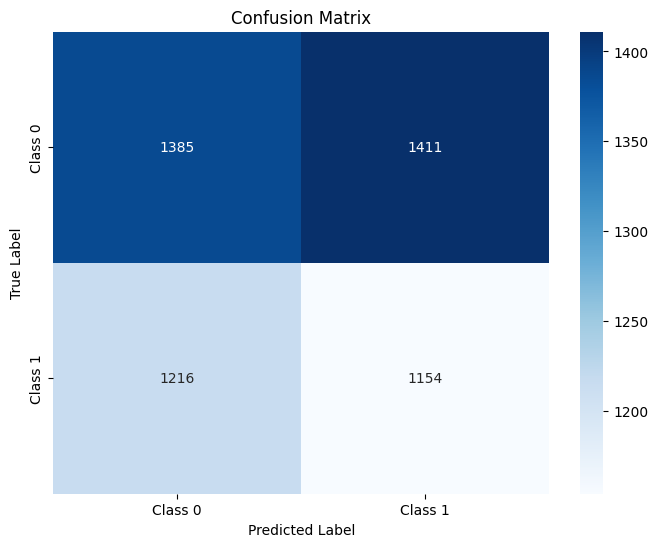

####################
Confusion Matrix Random Forest 0-1:


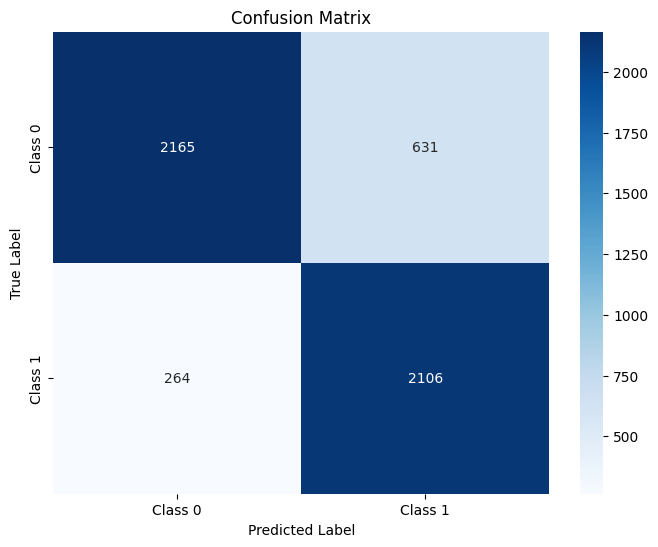

####################
Confusion Matrix XGBoost 0-1:


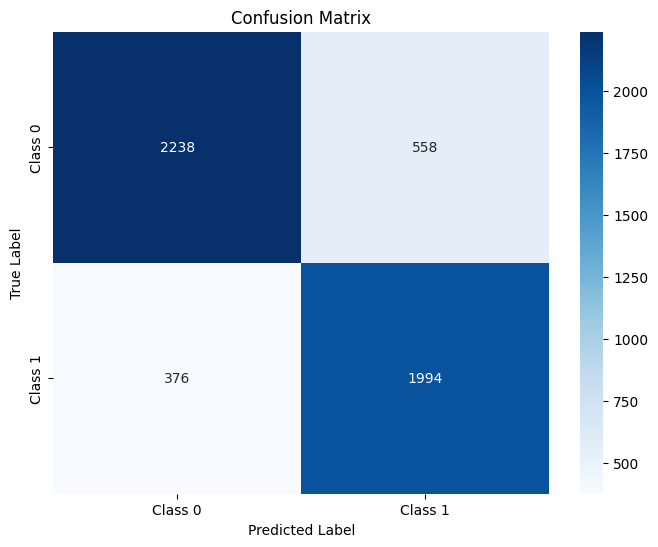

In [49]:
print('Confusion Matrix Baseline:')
show_confusion_matrix(test_y, pred_test_baseline)
print('#'*20)
print('Confusion Matrix Random Forest 0-1:')
show_confusion_matrix(test_y, pred_test)
print('#'*20)
print('Confusion Matrix XGBoost 0-1:')
show_confusion_matrix(test_y, pred_test_xgb)

ROC AUC curve Baseline:
####################
ROC AUC curve Random Forest 0-1:
####################
ROC AUC curve XGBoost 0-1:
####################
ROC AUC curve Random Forest Probabilities:
####################
ROC AUC curve XGBoost Probabilities:


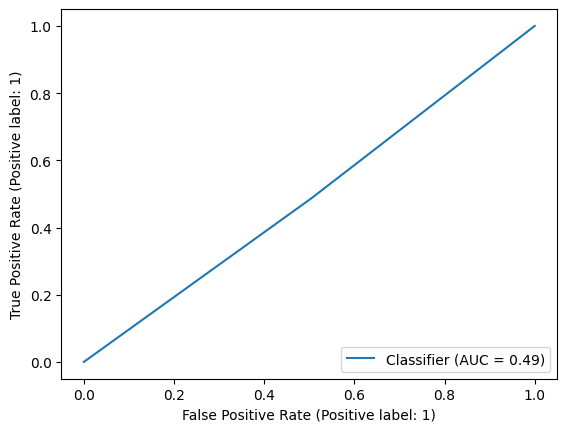

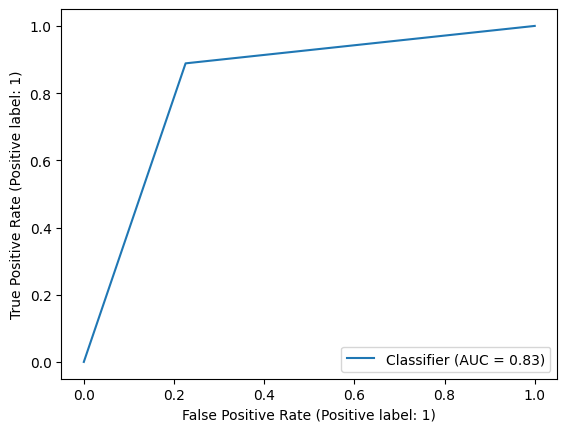

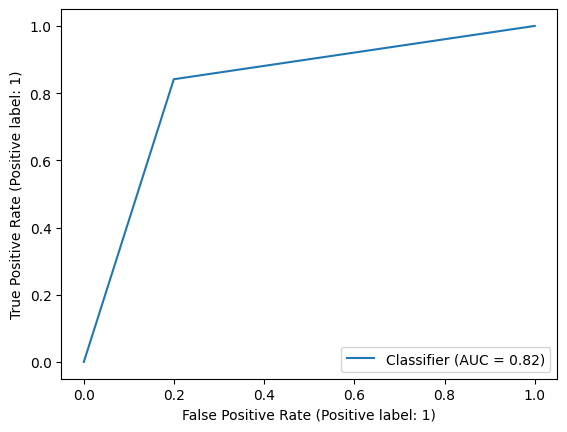

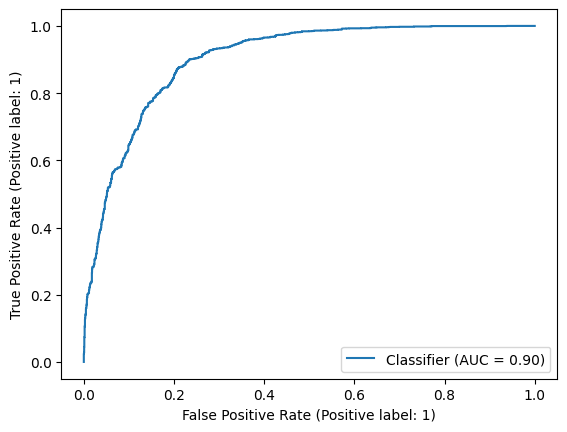

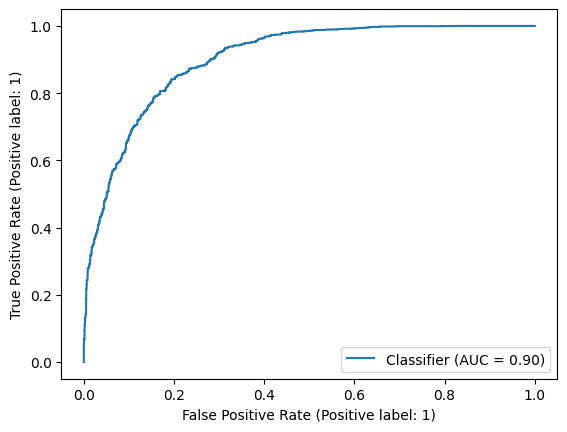

In [50]:
print('ROC AUC curve Baseline:')
print(RocCurveDisplay.from_predictions(test_y, pred_test_baseline))
print('#'*20)
print('ROC AUC curve Random Forest 0-1:')
print(RocCurveDisplay.from_predictions(test_y, pred_test))
print('#'*20)
print('ROC AUC curve XGBoost 0-1:')
print(RocCurveDisplay.from_predictions(test_y, pred_test_xgb))
print('#'*20)
print('ROC AUC curve Random Forest Probabilities:')
print(RocCurveDisplay.from_predictions(test_y, y_pred))
print('#'*20)
print('ROC AUC curve XGBoost Probabilities:')
print(RocCurveDisplay.from_predictions(test_y, y_pred_xgb))

In [51]:
# y_pred = model_stem.predict_proba(test_x)[:,1]
# y_pred_xgb = model_stem_xgb.predict_proba(test_x)[:,1]

y_pred_pv = model_rf.predict_proba(test_pv_x)[:,1]
y_pred_ej = model_rf.predict_proba(test_ej_x)[:,1]
y_pred_bp = model_rf.predict_proba(test_bp_x)[:,1]

y_pred_pv_xgb = model_xgb.predict_proba(test_pv_x)[:,1]
y_pred_ej_xgb = model_xgb.predict_proba(test_ej_x)[:,1]
y_pred_bp_xgb = model_xgb.predict_proba(test_bp_x)[:,1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps

In [52]:
test_df.columns

Index(['date', 'speaker_party', 'speaker_gender', 'speaker_id', 'term',
       'speech_text_preprocessed', 'party_in_power', 'speaker_age',
       'speech_text_preprocessed_tokenized', 'speech_text_preprocessed_len'],
      dtype='object')

In [53]:
pred_data_baseline = pd.DataFrame({'true': test_y, 'pred': pred_baseline, 'gender': test_df['speaker_gender'], 'term': test_df['term']})
pred_data = pd.DataFrame({'true': test_y, 'pred': y_pred, 'gender': test_df['speaker_gender'], 'term': test_df['term']})
pred_data_xgb = pd.DataFrame({'true': test_y, 'pred': y_pred_xgb, 'gender': test_df['speaker_gender'], 'term': test_df['term']})

pred_data_pv = pd.DataFrame({'true': test_pv_y, 'pred': y_pred_pv, 'gender': data_pv['speaker_gender'], 'term': data_pv['term']})
pred_data_ej = pd.DataFrame({'true': test_ej_y, 'pred': y_pred_ej, 'gender': data_ej['speaker_gender'], 'term': data_ej['term']})
pred_data_bp = pd.DataFrame({'true': test_bp_y, 'pred': y_pred_bp, 'gender': data_bp['speaker_gender'], 'term': data_bp['term']})

pred_data_pv_xgb = pd.DataFrame({'true': test_pv_y, 'pred': y_pred_pv_xgb, 'gender': data_pv['speaker_gender'], 'term': data_pv['term']})
pred_data_ej_xgb = pd.DataFrame({'true': test_ej_y, 'pred': y_pred_ej_xgb, 'gender': data_ej['speaker_gender'], 'term': data_ej['term']})
pred_data_bp_xgb = pd.DataFrame({'true': test_bp_y, 'pred': y_pred_bp_xgb, 'gender': data_bp['speaker_gender'], 'term': data_bp['term']})

In [54]:
display(pred_data)

,true,pred,gender,term
18,0,0.240740,0,4
19,1,0.428156,1,4
20,1,0.594272,0,4
21,1,0.594272,0,4
22,1,0.594272,0,4
...,...,...,...,...
15911,1,0.415029,1,2
15942,1,0.683068,0,2
15943,1,0.683068,0,2
15947,0,0.530992,1,2


In [55]:
male_pred = pred_data[pred_data['gender'] == 1]
fem_pred = pred_data[pred_data['gender'] == 0]

In [56]:
pred_data['term'].value_counts()

term
4    2484
2    1417
0     990
3     176
1      99
Name: count, dtype: int64

## Graphs:

### PSOE-PP test df:

First from the baseline model, next from random forest and finally from xgboost.

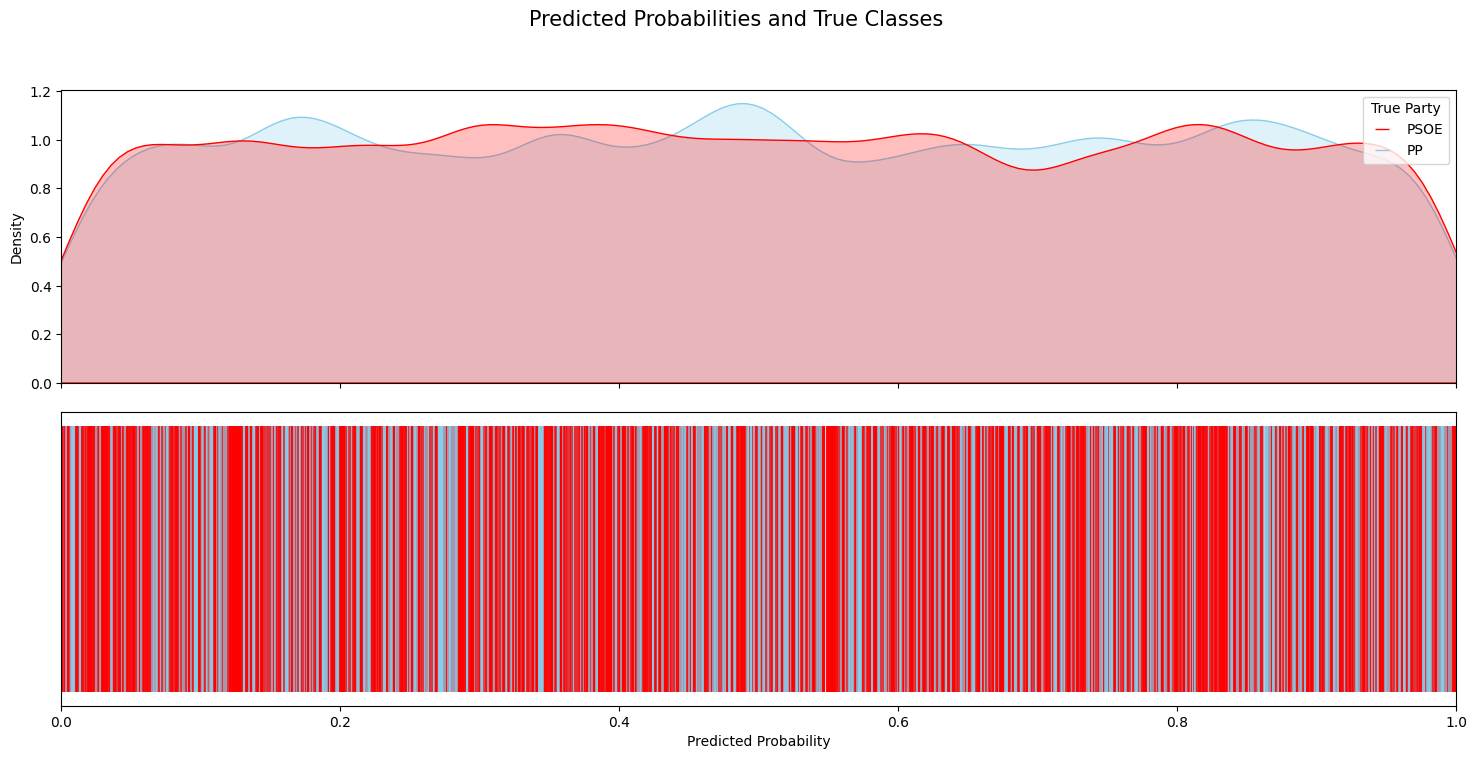

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines


# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_baseline[pred_data_baseline['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_baseline[pred_data_baseline['true'] == 0]['pred'], ax=axes[0], color='red', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='red', marker='_', linestyle='None', markersize=10, label='PSOE')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PP')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_baseline.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'red', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


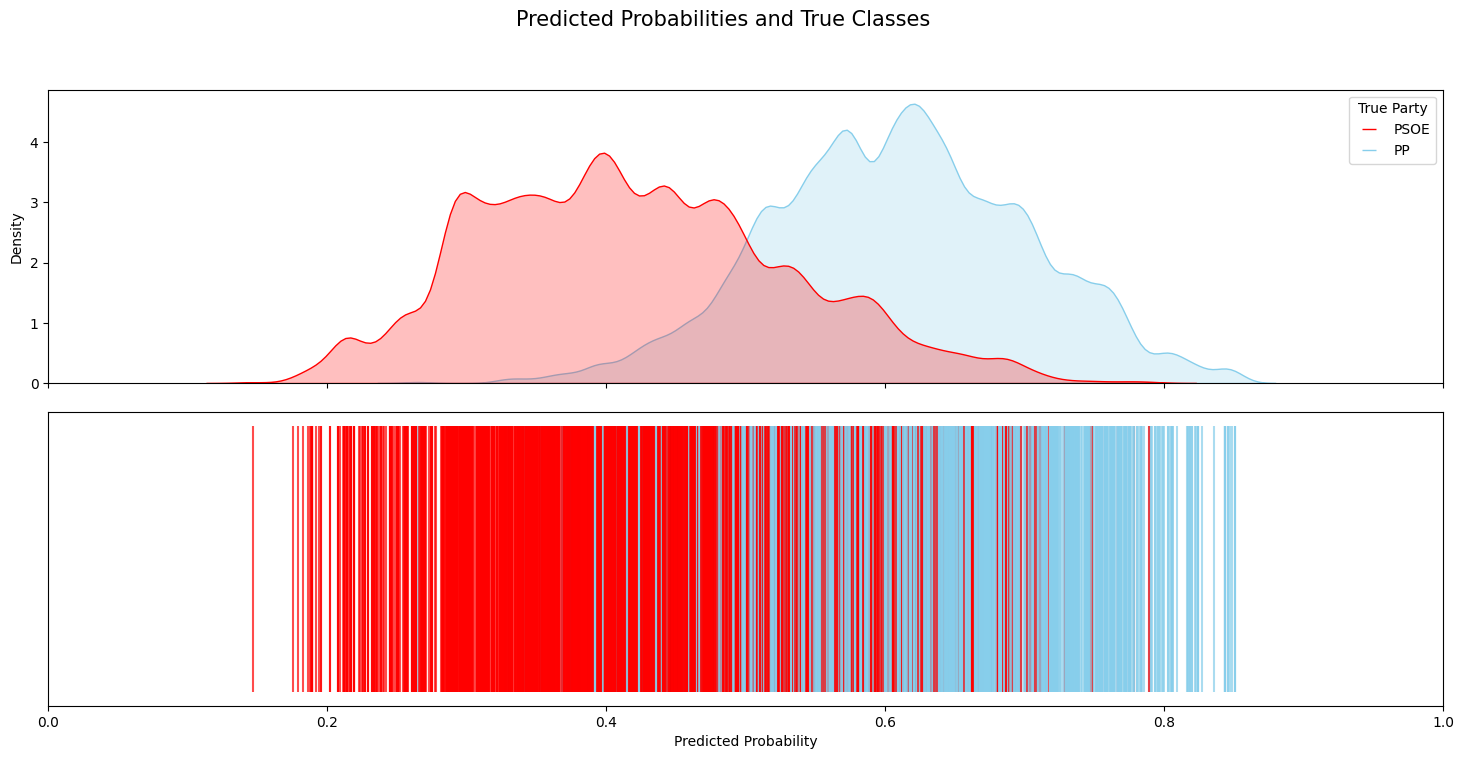

In [58]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data[pred_data['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data[pred_data['true'] == 0]['pred'], ax=axes[0], color='red', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='red', marker='_', linestyle='None', markersize=10, label='PSOE')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PP')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'red', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


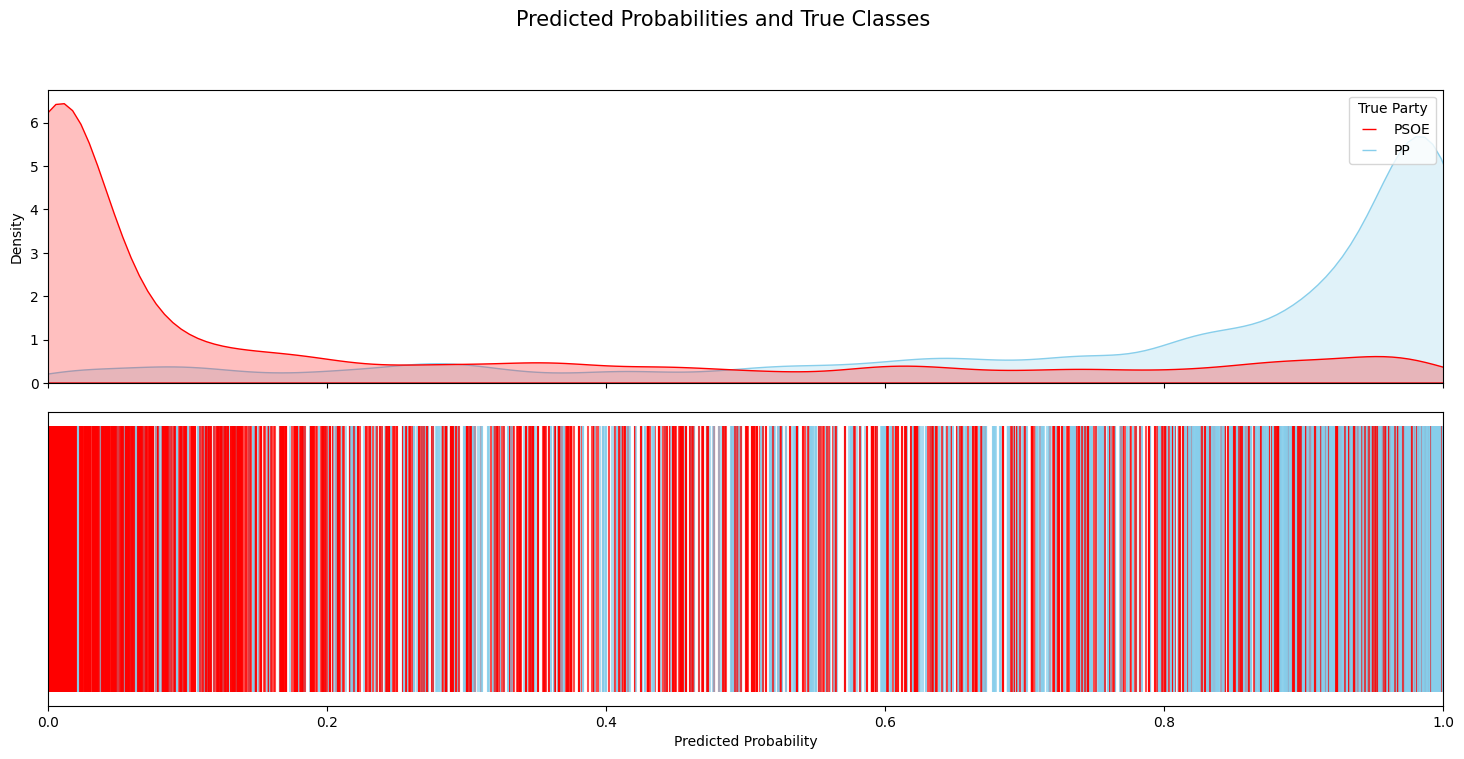

In [59]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_xgb[pred_data_xgb['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_xgb[pred_data_xgb['true'] == 0]['pred'], ax=axes[0], color='red', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='red', marker='_', linestyle='None', markersize=10, label='PSOE')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PP')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_xgb.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'red', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


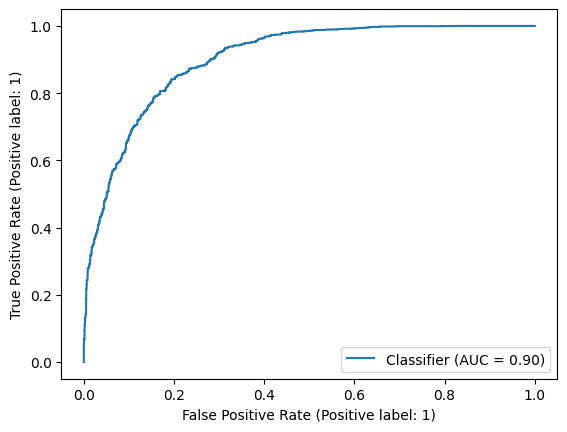

In [60]:
print(RocCurveDisplay.from_predictions(y_true = pred_data_xgb['true'], y_pred = pred_data_xgb['pred']))

In [72]:
pred_data_xgb

,true,pred,gender,term
18,0,0.000387,0,4
19,1,0.285946,1,4
20,1,0.581616,0,4
21,1,0.581616,0,4
22,1,0.581616,0,4
...,...,...,...,...
15911,1,0.481122,1,2
15942,1,0.988282,0,2
15943,1,0.988282,0,2
15947,0,0.869740,1,2


### Podemos-Vox test df:

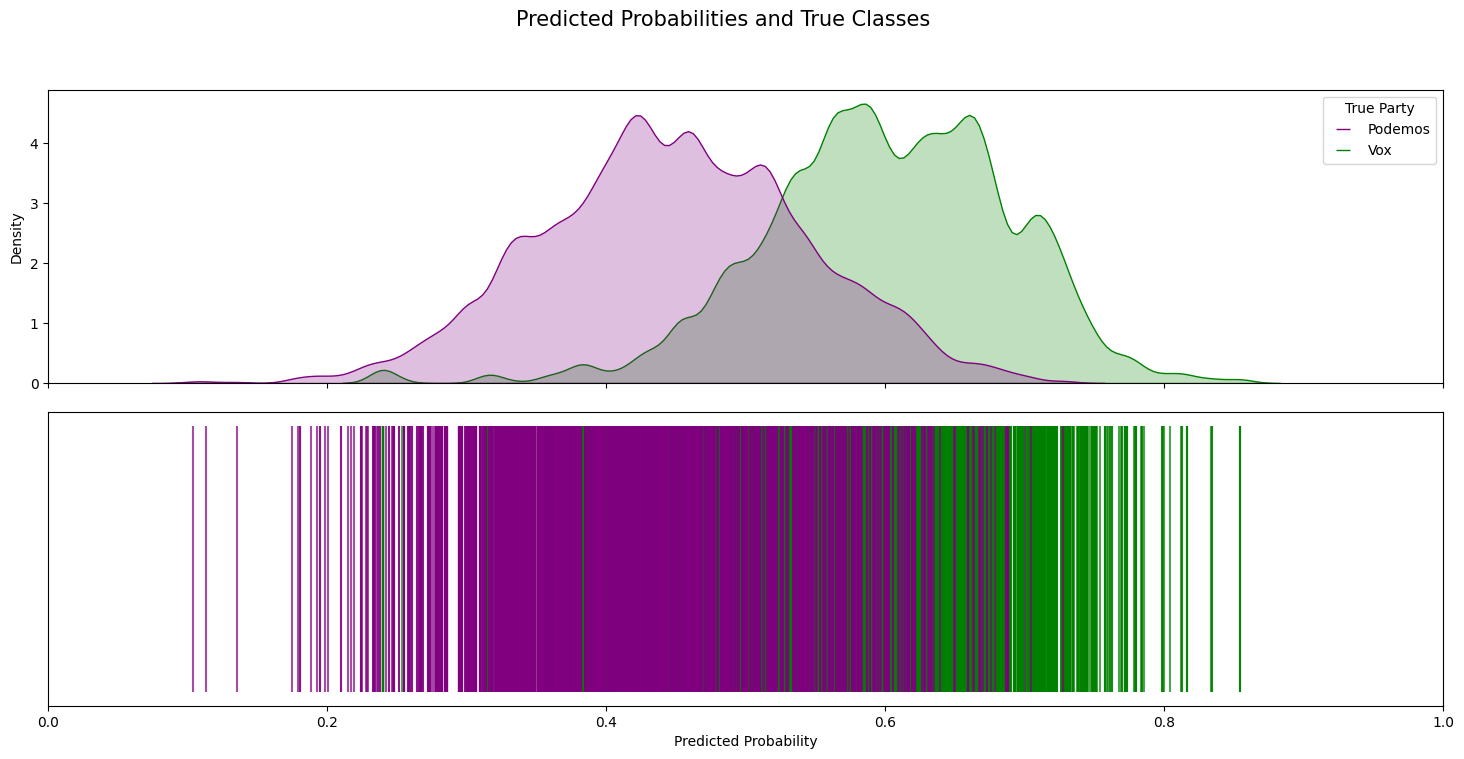

In [61]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_pv[pred_data_pv['true'] == 1]['pred'], ax=axes[0], color='green', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_pv[pred_data_pv['true'] == 0]['pred'], ax=axes[0], color='purple', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='purple', marker='_', linestyle='None', markersize=10, label='Podemos')
legend_class_1 = mlines.Line2D([], [], color='green', marker='_', linestyle='None', markersize=10, label='Vox')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_pv.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='green' if row['true'] == 1 else 'purple', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()

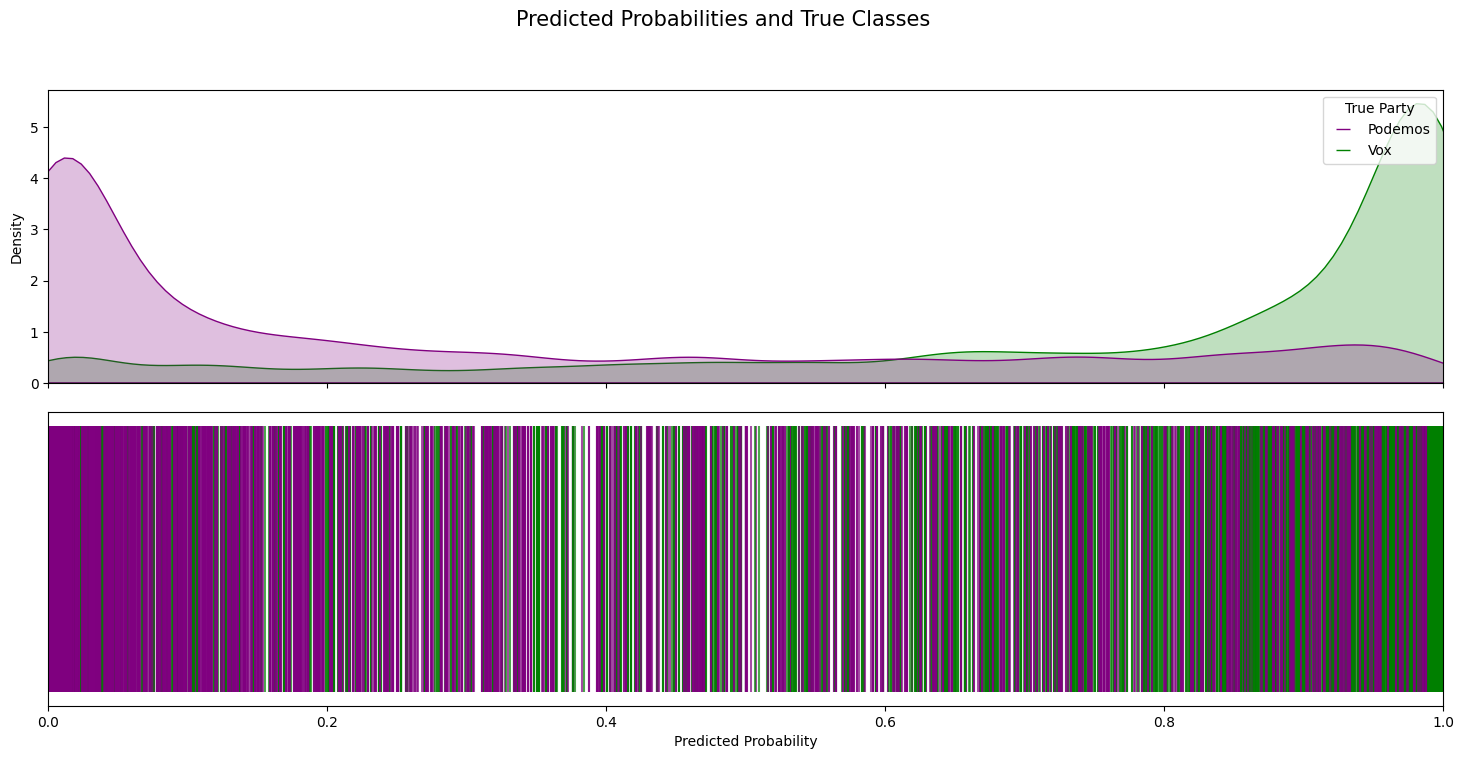

In [62]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_pv_xgb[pred_data_pv_xgb['true'] == 1]['pred'], ax=axes[0], color='green', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_pv_xgb[pred_data_pv_xgb['true'] == 0]['pred'], ax=axes[0], color='purple', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='purple', marker='_', linestyle='None', markersize=10, label='Podemos')
legend_class_1 = mlines.Line2D([], [], color='green', marker='_', linestyle='None', markersize=10, label='Vox')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_pv_xgb.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='green' if row['true'] == 1 else 'purple', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()

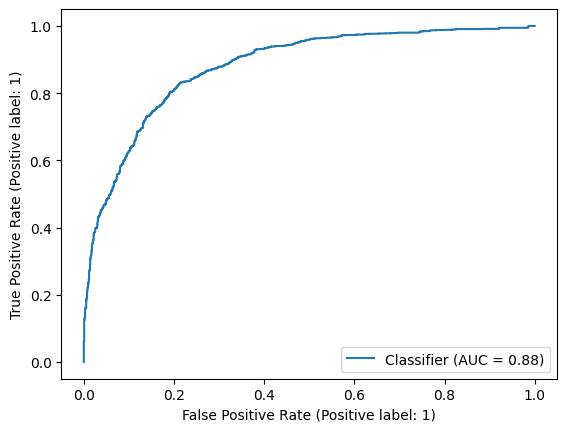

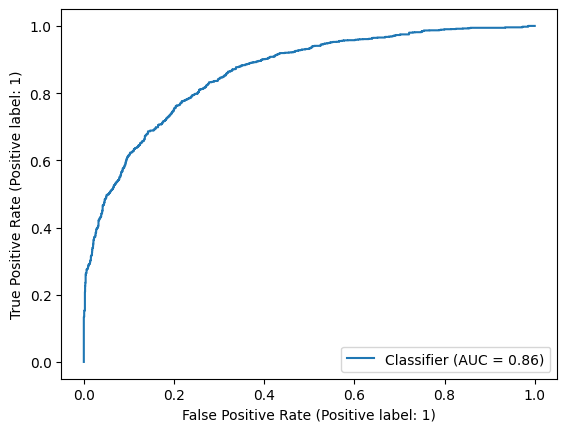

In [63]:
print(RocCurveDisplay.from_predictions(pred_data_pv['true'], pred_data_pv['pred']))
print(RocCurveDisplay.from_predictions(pred_data_pv_xgb['true'], pred_data_pv_xgb['pred']))

### ERC-JxCat test df:

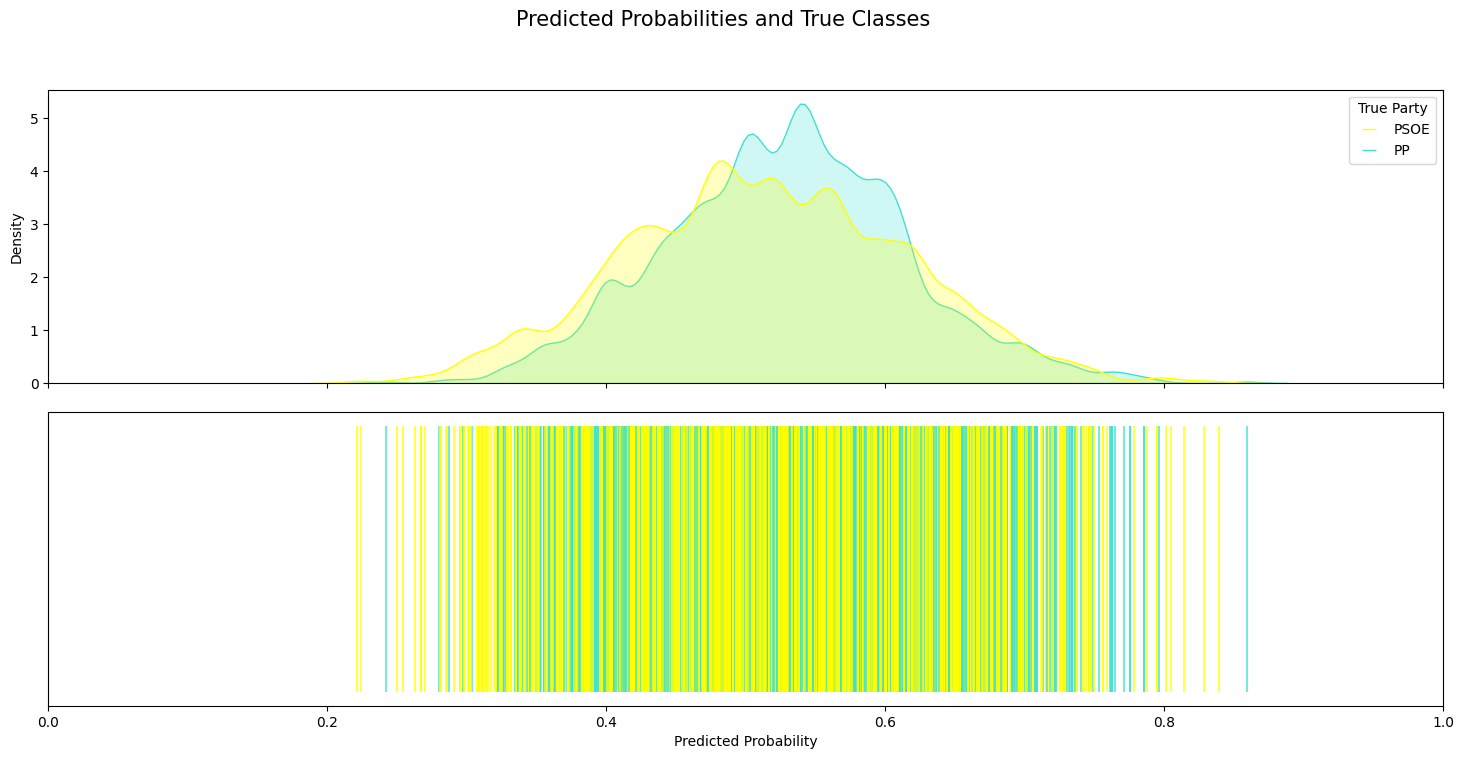

In [64]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_ej[pred_data_ej['true'] == 1]['pred'], ax=axes[0], color='turquoise', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_ej[pred_data_ej['true'] == 0]['pred'], ax=axes[0], color='yellow', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='yellow', marker='_', linestyle='None', markersize=10, label='PSOE')
legend_class_1 = mlines.Line2D([], [], color='turquoise', marker='_', linestyle='None', markersize=10, label='PP')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_ej.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='turquoise' if row['true'] == 1 else 'yellow', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


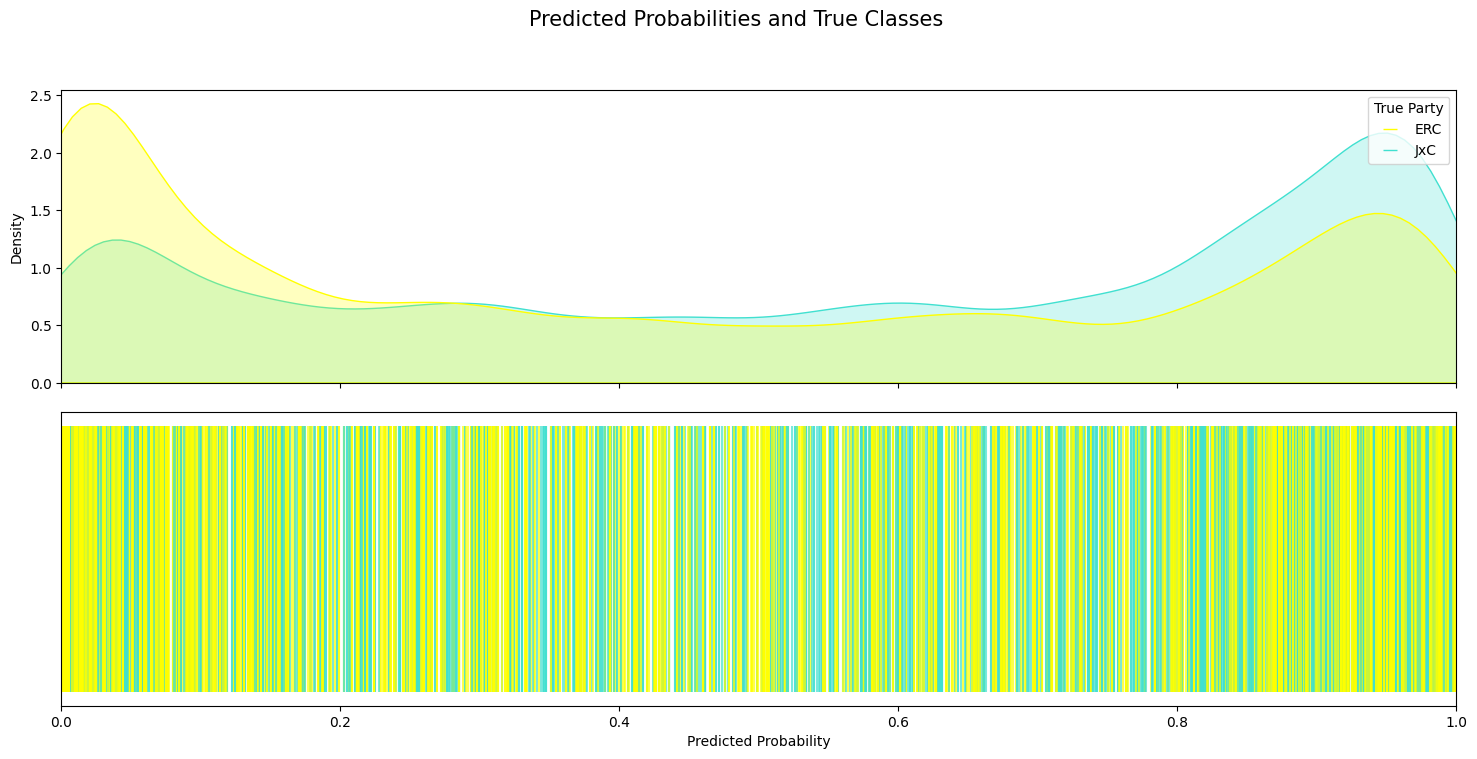

In [87]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_ej_xgb[pred_data_ej_xgb['true'] == 1]['pred'], ax=axes[0], color='turquoise', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_ej_xgb[pred_data_ej_xgb['true'] == 0]['pred'], ax=axes[0], color='yellow', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='yellow', marker='_', linestyle='None', markersize=10, label='ERC')
legend_class_1 = mlines.Line2D([], [], color='turquoise', marker='_', linestyle='None', markersize=10, label='JxC')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_ej_xgb.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='turquoise' if row['true'] == 1 else 'yellow', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()

### Bildu-PNV test df:

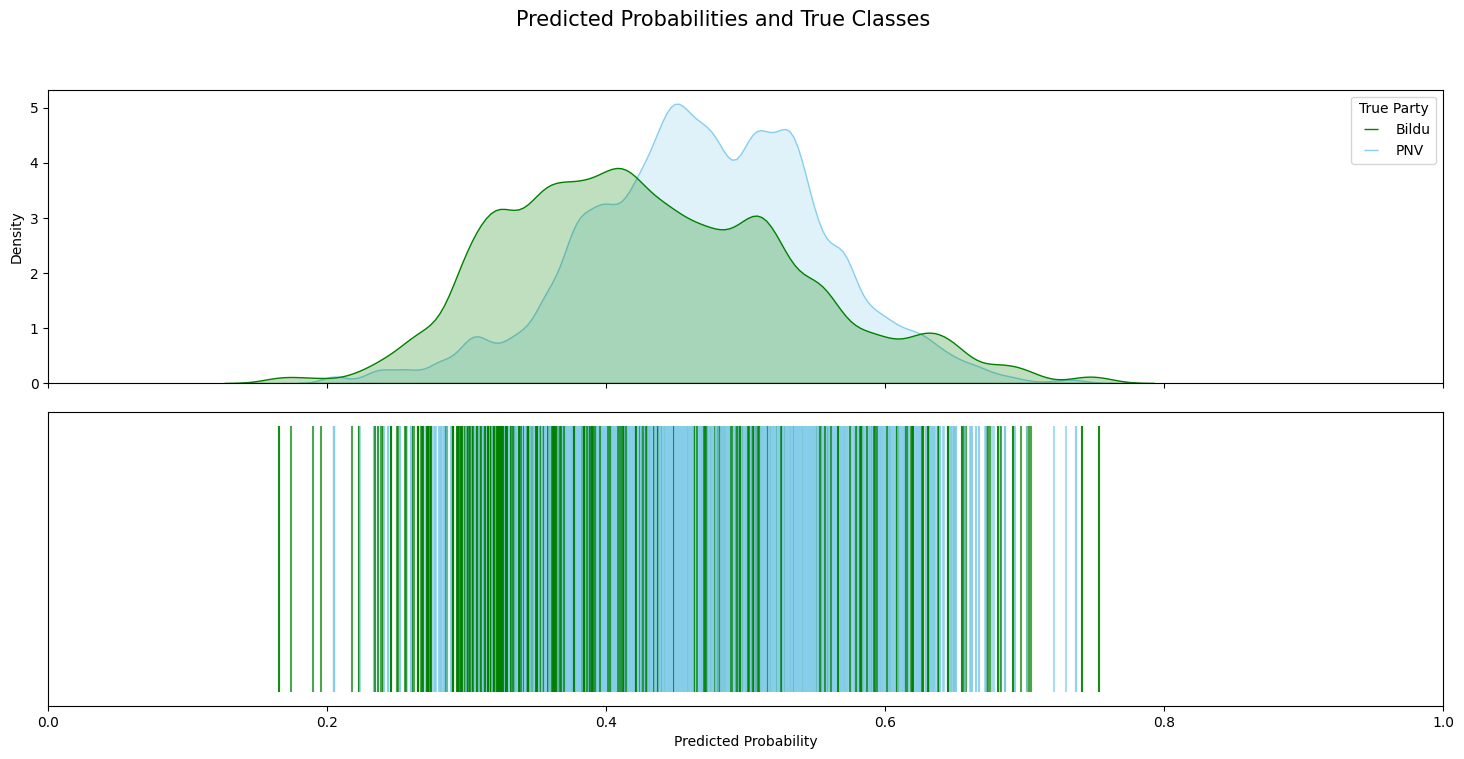

In [66]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_bp[pred_data_bp['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_bp[pred_data_bp['true'] == 0]['pred'], ax=axes[0], color='green', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='green', marker='_', linestyle='None', markersize=10, label='Bildu')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PNV')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_bp.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'green', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


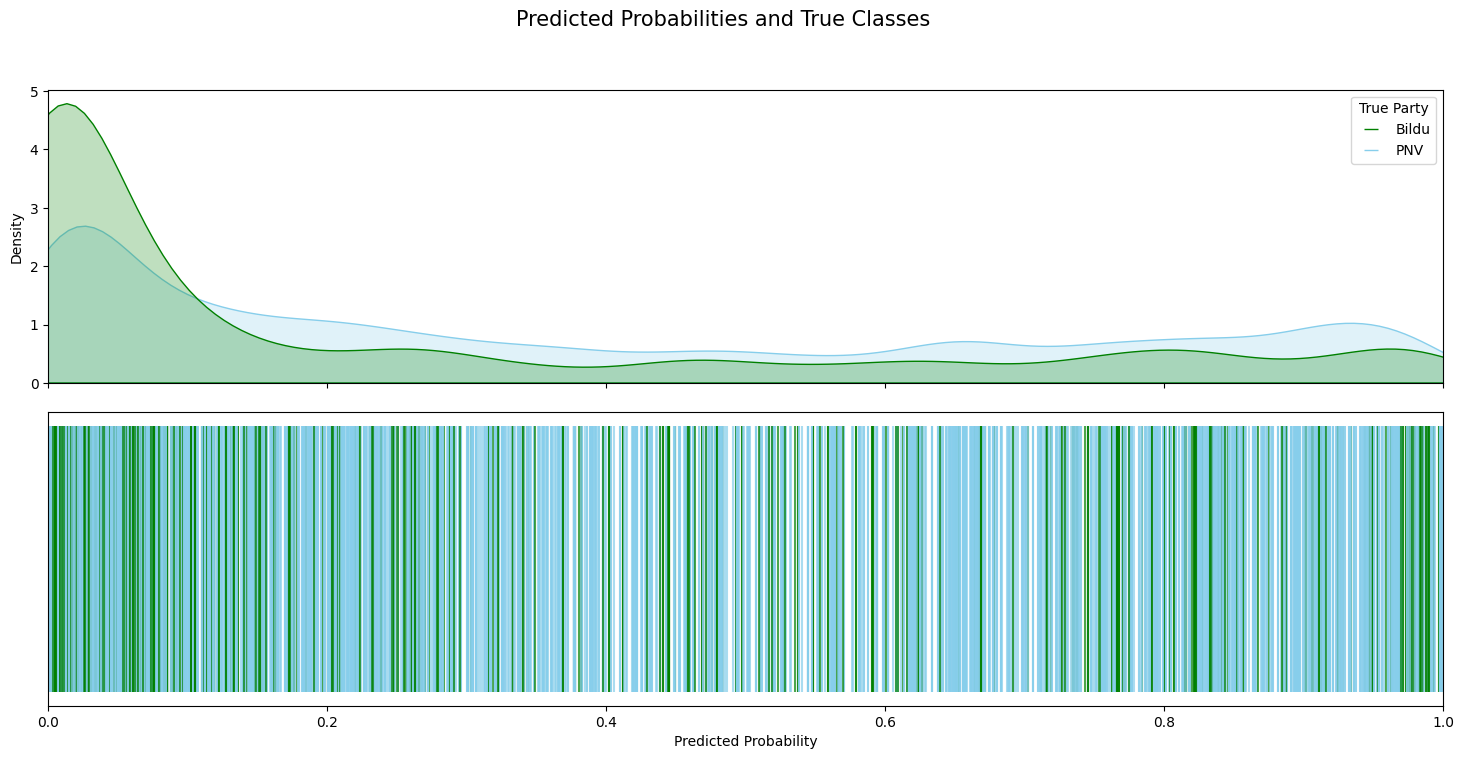

In [67]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=pred_data_bp_xgb[pred_data_bp_xgb['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=pred_data_bp_xgb[pred_data_bp_xgb['true'] == 0]['pred'], ax=axes[0], color='green', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='green', marker='_', linestyle='None', markersize=10, label='Bildu')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PNV')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in pred_data_bp_xgb.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'green', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()

PSOE-PP For Male Politicians:

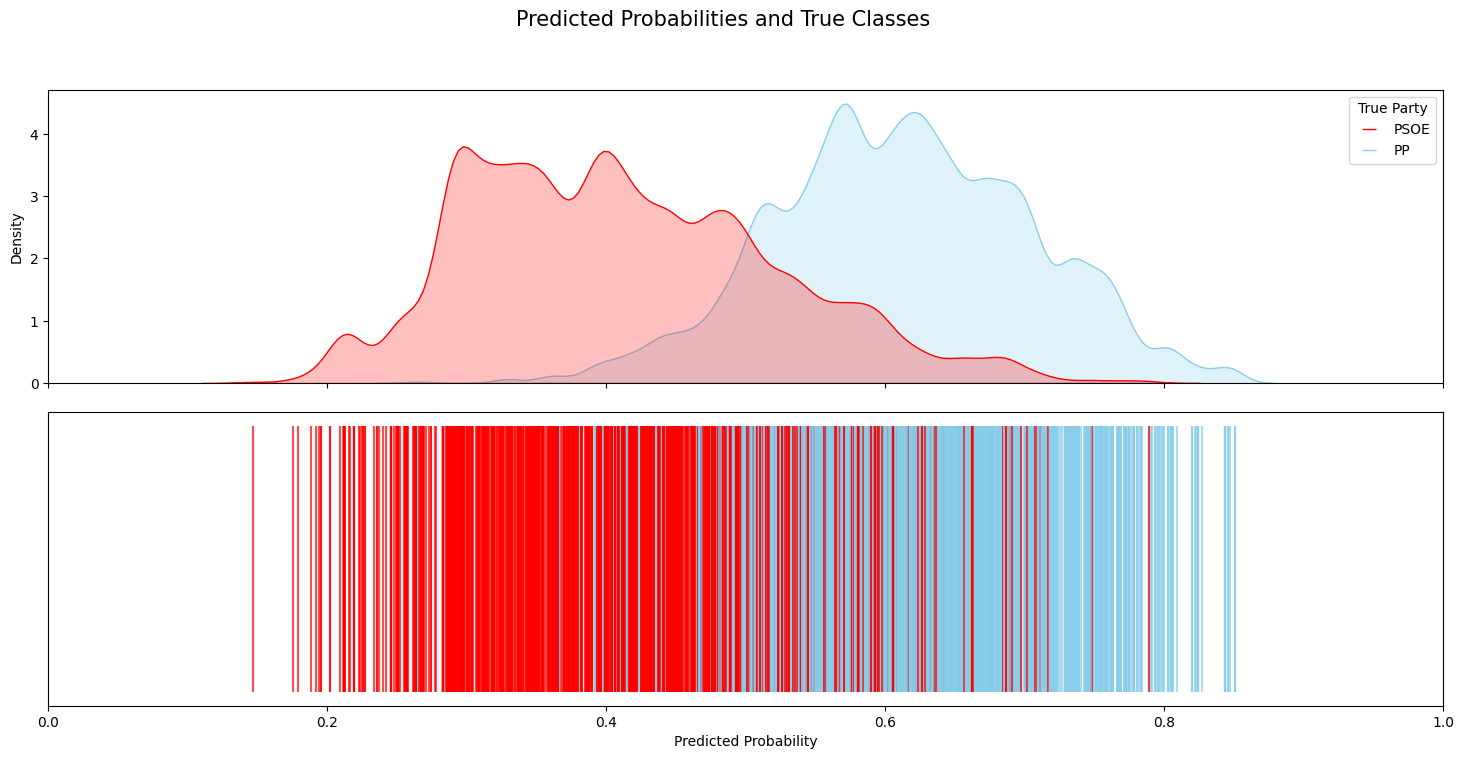

In [68]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=male_pred[male_pred['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=male_pred[male_pred['true'] == 0]['pred'], ax=axes[0], color='red', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='red', marker='_', linestyle='None', markersize=10, label='PSOE')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PP')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in male_pred.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'red', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


PSOE-PP For Female Politicians:

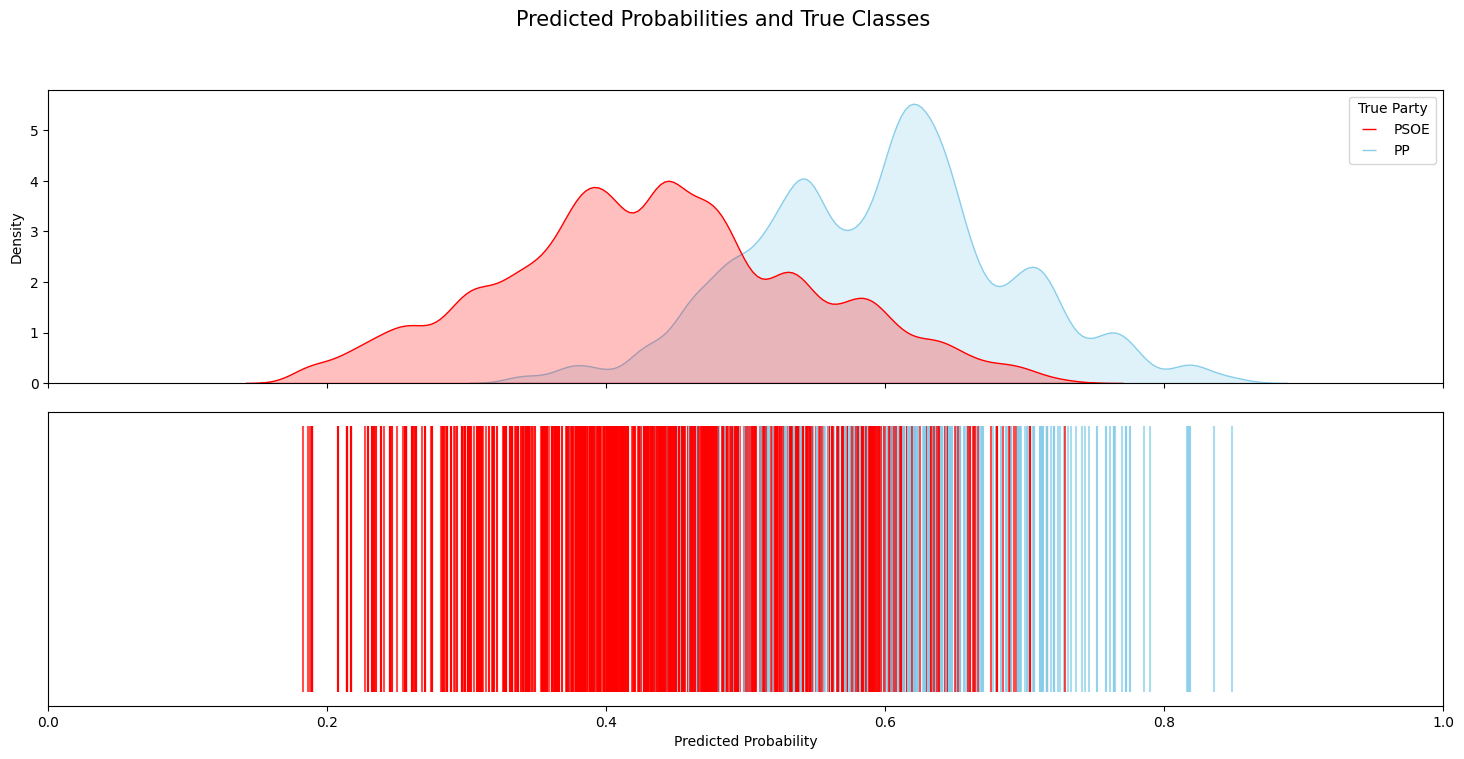

In [69]:
# Two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

# Plot density plots for each class on the first subplot (axes[0])
sns.kdeplot(data=fem_pred[fem_pred['true'] == 1]['pred'], ax=axes[0], color='skyblue', fill=True, bw_adjust=0.5)
sns.kdeplot(data=fem_pred[fem_pred['true'] == 0]['pred'], ax=axes[0], color='red', fill=True, bw_adjust=0.5)
axes[0].set_ylabel('Density')
axes[0].set_ylim(bottom=0)

# Custom legend for the bottom plot
legend_class_0 = mlines.Line2D([], [], color='red', marker='_', linestyle='None', markersize=10, label='PSOE')
legend_class_1 = mlines.Line2D([], [], color='skyblue', marker='_', linestyle='None', markersize=10, label='PP')
axes[0].legend(handles=[legend_class_0, legend_class_1], title='True Party')

# Plot vertical lines for each observation on the second subplot (axes[1])
for _, row in fem_pred.iterrows():
    axes[1].vlines(row['pred'], ymin=0, ymax=1, color='skyblue' if row['true'] == 1 else 'red', alpha=0.7)


# Common settings for the whole figure
axes[1].set_xlabel('Predicted Probability')
axes[1].set_yticks([])  # Hide y-axis ticks for the bottom plot
plt.xlim([0.0, 1.0])
plt.suptitle('Predicted Probabilities and True Classes', fontsize=15)

plt.show()


In [83]:
# feature importance graph with plotly express
# Extract feature importances from the 'clf' step of the pipeline
importances = model_xgb.named_steps['clf'].feature_importances_
feature_names = model_xgb.named_steps['tfidf'].get_feature_names_out()
indices = np.argsort(importances)[::-1]


fig = px.bar(
    x=importances[indices][:20],
    y=[feature_names[i] for i in indices][:20],
    orientation='h',
    title='Top 20 Feature Importances',
    labels={'x': 'Importance', 'y': 'Feature'}
)
fig.show()


In [86]:
# build dataframe with feature importances and feature names

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances.to_csv('features_importances.csv', index=False)

In [85]:
# Sorting features by their importance
indices = np.argsort(importances)[::-1]

# Selecting the top 100 words according to feature importance
top_50_importances = importances[indices][:50]
top_50_feature_names = [feature_names[i] for i in indices][:50]

# Creating a DataFrame for easier manipulation
df_top_50 = pd.DataFrame({
    'Feature': top_50_feature_names,
    'Importance': top_50_importances
})

# Now, to create a LaTeX table with the top 100 words in multiple columns, let's aim for a 4-column table.
# We'll reshape the DataFrame accordingly.

# Reshaping the DataFrame to have 4 columns for the LaTeX table
# The previous approach led to an error due to varying lengths of columns when dividing the top 100 features into three columns.
# Let's correct this by padding the shorter columns with empty strings to match the longest column's length.

# Calculating the exact numbers for three columns
num_rows = int(np.ceil(len(df_top_50) / 3))

# Creating arrays for each column, padding with empty strings where necessary
column_1 = df_top_50['Feature'][:num_rows].tolist() + [''] * (num_rows - len(df_top_50['Feature'][:num_rows]))
column_2 = df_top_50['Feature'][num_rows:2*num_rows].tolist() + [''] * (num_rows - len(df_top_50['Feature'][num_rows:2*num_rows]))
column_3 = df_top_50['Feature'][2*num_rows:3*num_rows].tolist() + [''] * (num_rows - len(df_top_50['Feature'][2*num_rows:3*num_rows]))

# To include the feature importance number as a column after each word column, 
# we need to adjust the DataFrame creation to account for these additional columns.

# Extending the DataFrame to include importance values next to each feature name
reshaped_with_importance = pd.DataFrame({
    'Feature 1': column_1,
    'Importance 1': df_top_50['Importance'][:num_rows].tolist() + [''] * (num_rows - len(df_top_50['Importance'][:num_rows])),
    'Feature 2': column_2,
    'Importance 2': df_top_50['Importance'][num_rows:2*num_rows].tolist() + [''] * (num_rows - len(df_top_50['Importance'][num_rows:2*num_rows])),
    'Feature 3': column_3,
    'Importance 3': df_top_50['Importance'][2*num_rows:3*num_rows].tolist() + [''] * (num_rows - len(df_top_50['Importance'][2*num_rows:3*num_rows])),
})

# Generating the LaTeX table code with importance numbers included
latex_table_with_importance = reshaped_with_importance.to_latex(index=False, escape=False)

print(latex_table_with_importance)


\begin{tabular}{lrlrll}
\toprule
Feature 1 & Importance 1 & Feature 2 & Importance 2 & Feature 3 & Importance 3 \\
\midrule
derecha & 0.038142 & izquierda & 0.004678 & término & 0.002546 \\
ciudadanía & 0.024661 & asunto & 0.004543 & comentar & 0.002514 \\
transformación & 0.011111 & elemento & 0.004511 & proyecto presupuesto & 0.002503 \\
socio & 0.010764 & 2016 & 0.004418 & millón español & 0.002464 \\
crear empleo & 0.008942 & recortar & 0.004065 & convalidación real & 0.002435 \\
cuestión & 0.008694 & ultraderecha & 0.004033 & mundo & 0.002373 \\
evidentemente & 0.008617 & extraordinario & 0.003891 & español española & 0.002241 \\
diputado bien & 0.007627 & digno & 0.003856 & pagar & 0.002240 \\
transición & 0.007456 & destruir & 0.003501 & español tener & 0.002175 \\
respecto & 0.007144 & indicar & 0.003105 & ciudadano ciudadana & 0.002162 \\
creación empleo & 0.006475 & colectivo & 0.003102 & historia & 0.002135 \\
pandemia & 0.006063 & inversión & 0.003018 & periodo & 0.002118 \